In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.6)
sns.set_style('whitegrid')
from sklearn.metrics import roc_curve, auc


def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')

In [2]:
df = pd.read_csv('41588_2019_417_MOESM3_ESM.csv', skiprows=2)
df = df[~df['Assembly accession number'].isna()]
df = df.rename(columns={'Assembly accession number':'GCA'})
df.head(2)

,Strain,Other Identifier,Country,Geographical Region,M Cluster,MLST,PopPUNK,Year,emm Family,emm Sub-type,...,Size (bp),N50 (bp),Insert size (average),Unnamed: 20,sample accession number,Reads,read length,Phred,AvgQual,Depth
0,NS2403,11826_4_60,Australia,Oceania,A-C5,ST335,98.0,2000,3,emm3.22,...,1767153.0,380038.0,245,NaN,ERS366814,1350000.0,100.0,33.0,36.5,73.0
1,NS2413,11826_4_61,Australia,Oceania,E6,ST109,63.0,2000,85,emm85.0,...,1784018.0,320921.0,225,NaN,ERS366815,1350000.0,100.0,33.0,36.6,73.0


In [260]:
protein = pd.read_csv('protein.txt.gz', sep='\t', header=None)
protein['Accession'] = protein[1].apply(lambda x: x.split(' ')[0])
protein['Multispecies'] = protein[1].apply(lambda x: x.split(' ')[1])
protein['Description'] = protein[1].apply(lambda x: ' '.join(x.split(' ')[2:]))
protein = protein.rename(columns={0:'GCA', 2:'Protein'})
protein = protein.drop(1, axis=1)
protein.head()

,GCA,Protein,Accession,Multispecies,Description
0,GCA_900983175,MSKTVVRKNESLDDALRRFKRSVTKAGTLQESRKREFYEKPSVKRK...,WP_000048058.1,MULTISPECIES:,30S ribosomal protein S21 [Streptococcus]
1,GCA_900983175,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus]
2,GCA_900983175,MDFLNHSFDTKKVINTKINAVNSKNNVGKNFIDVYREMKEVPNNKI...,WP_000346914.1,MULTISPECIES:,hypothetical protein [Streptococcus]
3,GCA_900983175,MERNQRKTLYGRVVSDKMDKTITVVVETKRNHPVYGKRINYSKKYK...,WP_000440811.1,MULTISPECIES:,30S ribosomal protein S17 [Streptococcus]
4,GCA_900983175,MGQKVHPIGMRVGIIRDWDAKWYAEKEYADYLHEDLAIRKFINKEL...,WP_000529929.1,MULTISPECIES:,30S ribosomal protein S3 [Streptococcus]


In [258]:
protein.shape

(2297542, 5)

In [4]:
eggnog = pd.read_csv('../doc/protein.99.eggnog.txt', sep='\t', header=None)
eggnog.columns = ['Accession', 'eggNOG', 'E-value', 'Bitscore']
eggnog.head()

,Accession,eggNOG,E-value,Bitscore
0,WP_060383938.1,4HDHN.faa.final_tree.fa,0.0,3746.3
1,WP_002989360.1,4HDHN.faa.final_tree.fa,0.0,3735.9
2,WP_047716015.1,4HDHN.faa.final_tree.fa,0.0,3735.5
3,WP_136293481.1,4HDHN.faa.final_tree.fa,0.0,3732.0
4,WP_136288169.1,4HDHN.faa.final_tree.fa,0.0,3731.1


In [5]:
new_df = pd.merge(protein, eggnog, on='Accession')
new_df.head()

,GCA,Protein,Accession,Multispecies,Description,eggNOG,E-value,Bitscore
0,GCA_900983175,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7
1,GCA_900983165,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7
2,GCA_900983155,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7
3,GCA_900983145,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7
4,GCA_900983215,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7


In [6]:
df1 = pd.merge(new_df, \
         df[['GCA', 'emm Family', 'emm Sub-type', 'tissue/source', 'Clinical', 'Invasive (pyseer)',]],\
        on='GCA')
df1.head()

,GCA,Protein,Accession,Multispecies,Description,eggNOG,E-value,Bitscore,emm Family,emm Sub-type,tissue/source,Clinical,Invasive (pyseer)
0,GCA_900983175,MAVPARHTSKAKKNKRRTHYKLTAPSVQFDETTGDYSRSHRVSLKG...,WP_000290414.1,MULTISPECIES:,50S ribosomal protein L32 [Streptococcus],4HR2Q.faa.final_tree.fa,3.400000e-35,120.7,3,emm3.22,skin sore / abscess / burns / IV Site,APSGN,0
1,GCA_900983175,MDFLNHSFDTKKVINTKINAVNSKNNVGKNFIDVYREMKEVPNNKI...,WP_000346914.1,MULTISPECIES:,hypothetical protein [Streptococcus],4HJZW.faa.final_tree.fa,1.400000e-02,16.5,3,emm3.22,skin sore / abscess / burns / IV Site,APSGN,0
2,GCA_900983175,MERNQRKTLYGRVVSDKMDKTITVVVETKRNHPVYGKRINYSKKYK...,WP_000440811.1,MULTISPECIES:,30S ribosomal protein S17 [Streptococcus],4HKDN.faa.final_tree.fa,3.500000e-49,165.8,3,emm3.22,skin sore / abscess / burns / IV Site,APSGN,0
3,GCA_900983175,MGQKVHPIGMRVGIIRDWDAKWYAEKEYADYLHEDLAIRKFINKEL...,WP_000529929.1,MULTISPECIES:,30S ribosomal protein S3 [Streptococcus],4HAUR.faa.final_tree.fa,9.700000e-126,418.7,3,emm3.22,skin sore / abscess / burns / IV Site,APSGN,0
4,GCA_900983175,MGRSLKKGPFVDEHLMKKVEAQANDEKKKVIKTWSRRSTIFPSFIG...,WP_000533765.1,MULTISPECIES:,30S ribosomal protein S19 [Streptococcaceae],4HIG0.faa.final_tree.fa,8.300000e-59,196.8,3,emm3.22,skin sore / abscess / burns / IV Site,APSGN,0


In [19]:
clinical = df1.Clinical.value_counts().index
clinical

Index(['Superficial soft tissue infection', 'iGAS',
       'Deep soft tissue infection', 'Pharyngitis', 'ND', 'Rheumatic fever',
       'Pneumonia', 'Scarlet fever', 'APSGN', 'Meningitis', 'Bacteremia',
       'Genital', 'Arthritis', 'Necrotising fasciitis', 'Fever',
       'SOB & asthma'],
      dtype='object')

In [72]:
def calculate_auc(clinical_name):
    test_df = df1.copy()
    test_df['Label'] = test_df['Clinical'].apply(lambda x: 1 if x == clinical_name else 0)
    
    all_eggNOGs = test_df['eggNOG'].value_counts().index
    
    auc_df = pd.DataFrame(columns=['Clinical', 'AUC'])
    
    for p, q in enumerate(all_eggNOGs):
        nn = test_df[test_df['eggNOG'] == q].copy()
        if len(nn.Label.value_counts()) == 2:
            nn.Label.value_counts().values[0]
            fpr, tpr, _ = roc_curve(nn.Label, nn.Bitscore)
            auc_df.loc[q, 'Clinical'] = clinical_name
            auc_df.loc[q, 'AUC'] = auc(fpr, tpr)
            auc_df.loc[q, 'Negative [0]'] = nn.Label.value_counts().values[0]
            auc_df.loc[q, 'Positive [1]'] = nn.Label.value_counts().values[1]
    return auc_df

In [54]:
# calculate_auc(clinical[0])

In [73]:
from multiprocessing import Pool


pools = Pool(len(clinical))
results = []
for result in pools.imap(calculate_auc, clinical):
    results.append(result)
    progress(len(results), len(clinical))
pools.close()
pools.join()

|██████████████████████████████████████████████████| 100% (16/16)  
Completed!


In [134]:
auc_df_all = pd.concat(results)
auc_df_all['Negative [0]'] = auc_df_all['Negative [0]'].astype(int)
auc_df_all['Positive [1]'] = auc_df_all['Positive [1]'].astype(int)
auc_df_all.to_pickle('results/auc_df.pkl.gz')
auc_df_all.head()

,Clinical,AUC,Negative [0],Positive [1]
4ITXI.faa.final_tree.fa,Superficial soft tissue infection,0.513291,1762,732
4HAB1.faa.final_tree.fa,Superficial soft tissue infection,0.489754,1570,592
4HBMF.faa.final_tree.fa,Superficial soft tissue infection,0.492136,1512,598
4HAV8.faa.final_tree.fa,Superficial soft tissue infection,0.47045,1494,595
4H9UY.faa.final_tree.fa,Superficial soft tissue infection,0.517703,1393,608


In [7]:
auc_df_all = pd.read_pickle('results/auc_df.pkl.gz')
auc_df_all.head()

,Clinical,AUC,Negative [0],Positive [1]
4ITXI.faa.final_tree.fa,Superficial soft tissue infection,0.513291,1762,732
4HAB1.faa.final_tree.fa,Superficial soft tissue infection,0.489754,1570,592
4HBMF.faa.final_tree.fa,Superficial soft tissue infection,0.492136,1512,598
4HAV8.faa.final_tree.fa,Superficial soft tissue infection,0.47045,1494,595
4H9UY.faa.final_tree.fa,Superficial soft tissue infection,0.517703,1393,608


In [23]:
# auc_df_all[auc_df_all['AUC'] == 1]

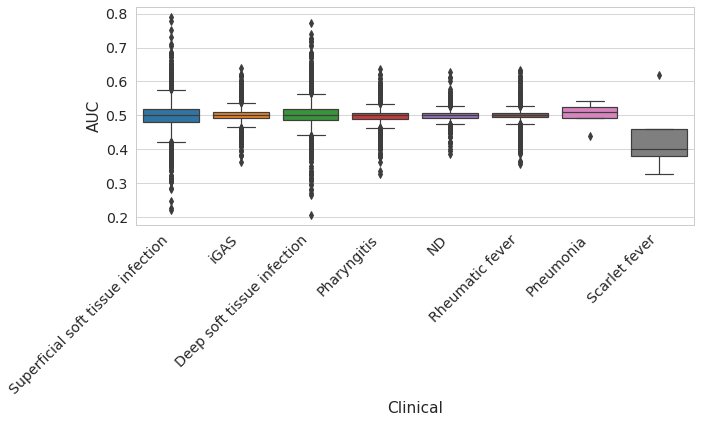

In [14]:
plt.figure(figsize=(10, 4))

# Taking those with N > 100

plot_df = auc_df_all[(auc_df_all['Positive [1]'] > 50) \
                     & (auc_df_all['Negative [0]'] > 50 )].copy()

ax = sns.boxplot(data=plot_df[['Clinical', 'AUC']], x='Clinical', y='AUC')
plt.xticks(rotation=45, ha='right');

In [15]:
max_aucs = pd.DataFrame(plot_df.groupby('Clinical')['AUC'].apply(max))
max_aucs

,AUC
Clinical,
Deep soft tissue infection,0.772738
ND,0.627547
Pharyngitis,0.637038
Pneumonia,0.543098
Rheumatic fever,0.634246
Scarlet fever,0.619704
Superficial soft tissue infection,0.789752
iGAS,0.639356


In [16]:
min_aucs = pd.DataFrame(plot_df.groupby('Clinical')['AUC'].apply(min))
1- min_aucs

,AUC
Clinical,
Deep soft tissue infection,0.793257
ND,0.615463
Pharyngitis,0.672727
Pneumonia,0.561862
Rheumatic fever,0.644164
Scarlet fever,0.673801
Superficial soft tissue infection,0.779254
iGAS,0.638675


#### Max AUCs

In [20]:
aa = []

for i, v in enumerate(clinical):
    try:
        aa.append(plot_df[plot_df['AUC'] == max_aucs['AUC'][v]])
    except Exception:
        pass

pd.concat(aa)

,Clinical,AUC,Negative [0],Positive [1]
4HCXD.faa.final_tree.fa,Superficial soft tissue infection,0.789752,206,90
4HRJP.faa.final_tree.fa,iGAS,0.639356,252,51
4I6BX.faa.final_tree.fa,Deep soft tissue infection,0.772738,739,103
4I2TY.faa.final_tree.fa,Pharyngitis,0.637038,553,78
4IPJU.faa.final_tree.fa,ND,0.627547,572,58
4IPT0.faa.final_tree.fa,Rheumatic fever,0.634246,727,62
4HAV8.faa.final_tree.fa,Pneumonia,0.543098,2025,64
4HUGW.faa.final_tree.fa,Scarlet fever,0.619704,1225,51


In [205]:
choosen_eggnogs = {}

temp_df = plot_df.copy()
temp_df['AUC'] = temp_df['AUC'].apply(lambda x: x if x > 0.5 else 1-x) 

choosen_clinical = temp_df.Clinical.value_counts().index

for i, v in enumerate(choosen_clinical):
    choosen_eggnogs[v] = temp_df[temp_df.Clinical == \
                                                v].sort_values('AUC', ascending=False)[:10].index
choosen_eggnogs

{'Superficial soft tissue infection': Index(['4HCXD.faa.final_tree.fa', '4HACW.faa.final_tree.fa',
        '4HM73.faa.final_tree.fa', '4HACE.faa.final_tree.fa',
        '4HD40.faa.final_tree.fa', '4HHRE.faa.final_tree.fa',
        '4HA4N.faa.final_tree.fa', '4HM7N.faa.final_tree.fa',
        '4HM7S.faa.final_tree.fa', '4HKMU.faa.final_tree.fa'],
       dtype='object'),
 'iGAS': Index(['4HRJP.faa.final_tree.fa', '4IV0S.faa.final_tree.fa',
        '4I677.faa.final_tree.fa', '4HVHU.faa.final_tree.fa',
        '4HD40.faa.final_tree.fa', '4HBVA.faa.final_tree.fa',
        '4HAD8.faa.final_tree.fa', '4HC14.faa.final_tree.fa',
        '4ISEA.faa.final_tree.fa', '4HABP.faa.final_tree.fa'],
       dtype='object'),
 'Deep soft tissue infection': Index(['4I2TY.faa.final_tree.fa', '4I6BX.faa.final_tree.fa',
        '4HBE3.faa.final_tree.fa', '4HEWB.faa.final_tree.fa',
        '4IV0S.faa.final_tree.fa', '4HAS9.faa.final_tree.fa',
        '4HB7M.faa.final_tree.fa', '4HKGF.faa.final_tree.fa',
       

In [257]:
choosen_clinical

Index(['Superficial soft tissue infection', 'iGAS',
       'Deep soft tissue infection', 'Pharyngitis', 'ND', 'Rheumatic fever',
       'Pneumonia', 'Scarlet fever'],
      dtype='object')

In [199]:
def make_features(clinical):
    ## subset df with top models for given clinical
    sub_df = df1[df1.eggNOG.apply(lambda x: x in choosen_eggnogs[clinical].tolist())].copy()
    sub_df['Label'] = sub_df['Clinical'].apply(lambda x: 1 if x == clinical else 0)
    
    # GCAs
    gca = sub_df['GCA'].value_counts().index
    
    # eggNOG models for this clinical
    egg = choosen_eggnogs[clinical].tolist()
    
    # medians for NaNs
    med_df = pd.DataFrame(sub_df.groupby('eggNOG')['Bitscore'].median())
    
    # feature df
    feat_df = pd.DataFrame(columns=egg, index=gca)
    for i, v in enumerate(gca):
        for p, q in enumerate(egg):
            try:
                bitsc = sub_df[(sub_df.GCA == v) & (sub_df.eggNOG == q)]['Bitscore'].values[0]
            except Exception as exp:
#                 print(str(exp))
                bitsc = med_df.loc[q, 'Bitscore']
            feat_df.loc[v, q] = bitsc
        
    feat_df = feat_df.reset_index()
    feat_df = feat_df.rename(columns={'index':'GCA'})
    feat_df = pd.merge(feat_df, sub_df[['GCA', 'Label']], on='GCA')
    return med_df, feat_df



In [242]:
from sklearn.ensemble import RandomForestClassifier



med_dfs = {}
feat_dfs = {}
choosen_models = {}
classifiers = {}

for i, v in enumerate(choosen_clinical):
    med, feat = make_features(v)
    med_dfs[v] = med
    feat_dfs[v] = feat
    choosen_models[v] = choosen_eggnogs[v]

    X, y = feat[choosen_eggnogs[v]], feat.Label
    clf = RandomForestClassifier(random_state=12345)
    clf.fit(X, y)

    classifiers[v] = clf
    progress(i, len(choosen_clinical))


In [253]:
results = [med_dfs, feat_dfs, choosen_models, classifiers]
results_name = ['Medians', 'Features', 'Choosen_Models', 'Classifiers']

import pickle

for i, v in enumerate(results):
    with open('results/{}.pkl'.format(results_name[i]), 'wb') as handle:
        pickle.dump(a, handle)

In [263]:
feat_dfs['Superficial soft tissue infection']

,GCA,4HCXD.faa.final_tree.fa,4HACW.faa.final_tree.fa,4HM73.faa.final_tree.fa,4HACE.faa.final_tree.fa,4HD40.faa.final_tree.fa,4HHRE.faa.final_tree.fa,4HA4N.faa.final_tree.fa,4HM7N.faa.final_tree.fa,4HM7S.faa.final_tree.fa,4HKMU.faa.final_tree.fa,Label
0,GCA_900993285,362.3,800.8,173.1,783.3,472.5,300.4,503.8,209.9,304,157,0
1,GCA_900993285,362.3,800.8,173.1,783.3,472.5,300.4,503.8,209.9,304,157,0
2,GCA_900993285,362.3,800.8,173.1,783.3,472.5,300.4,503.8,209.9,304,157,0
3,GCA_900993285,362.3,800.8,173.1,783.3,472.5,300.4,503.8,209.9,304,157,0
4,GCA_900993285,362.3,800.8,173.1,783.3,472.5,300.4,503.8,209.9,304,157,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2342,GCA_900986675,365.6,799.3,173.9,783.3,470.7,300.4,503.8,209.9,304.1,158,1
2343,GCA_900983585,365.6,799.3,173.1,783.3,472.5,300.4,503.8,209.9,304.1,158,0
2344,GCA_900992965,365.6,799.3,173.1,783.3,470.7,300.4,505.9,209.9,304.1,158,0
2345,GCA_900983415,365.6,799.3,173.1,783.3,470.7,300.4,503.8,209.9,304.1,158,1


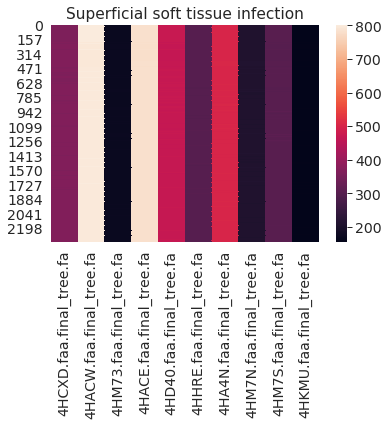

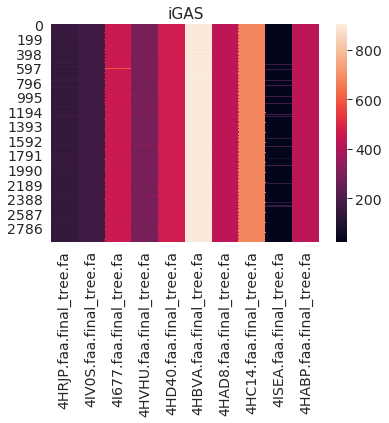

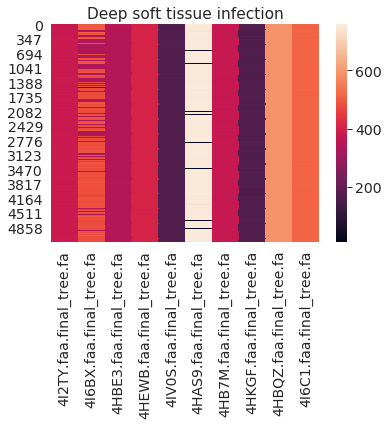

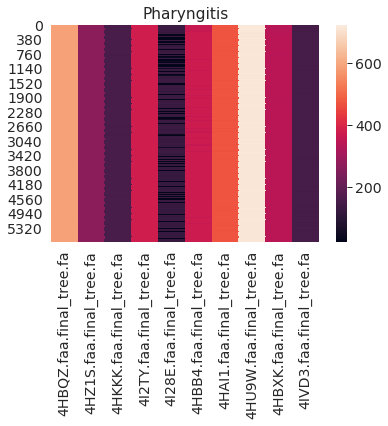

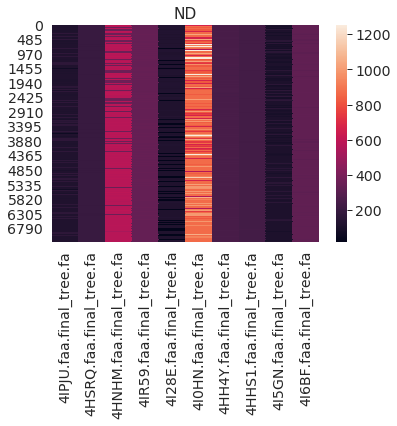

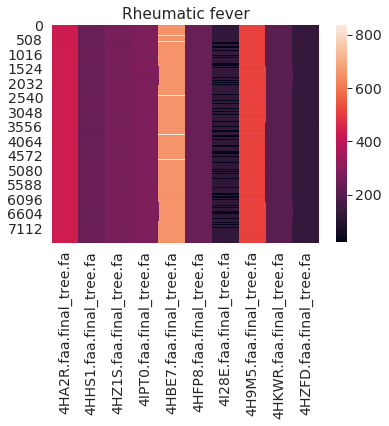

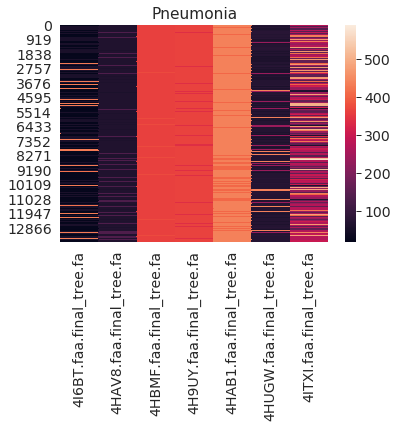

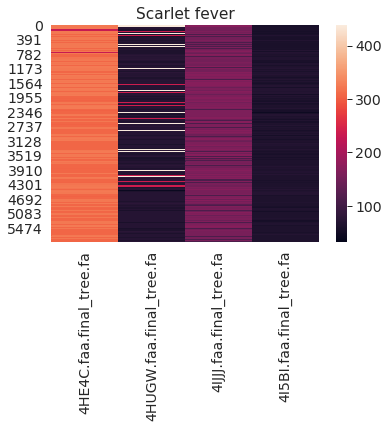

In [256]:
for k, v in feat_dfs.items():
    ax = sns.heatmap(v[choosen_models[k]].astype(float))
    ax.set_title(k)
    plt.show()

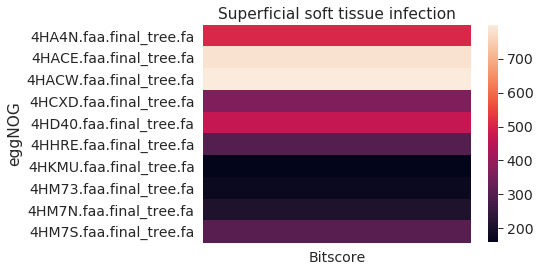

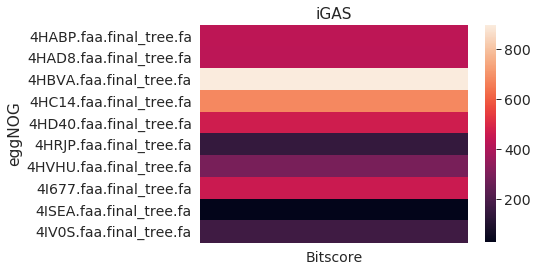

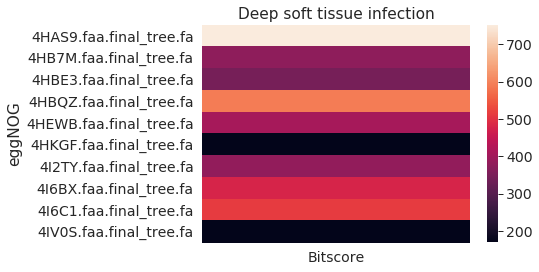

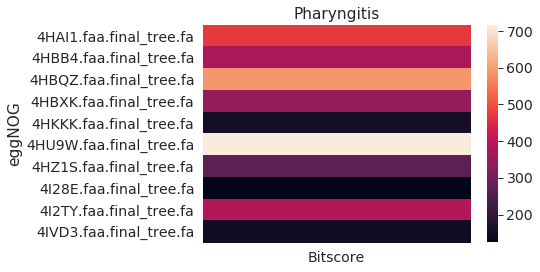

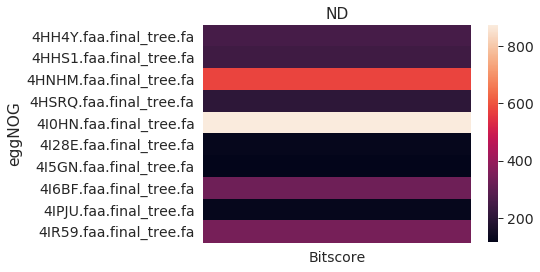

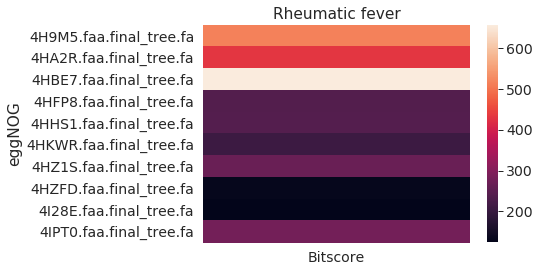

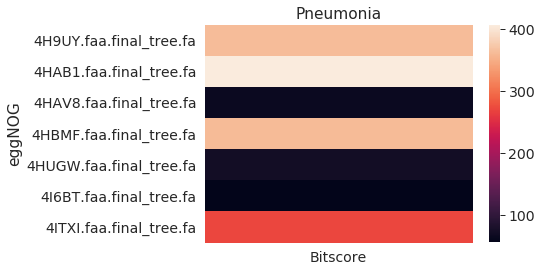

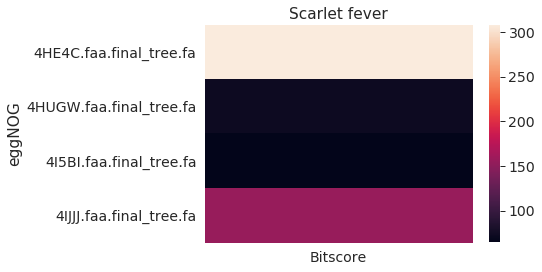

In [255]:
for k, v in med_dfs.items():
    ax = sns.heatmap(v.astype(float))
    ax.set_title(k)
    plt.show()